In [ ]:
import json

def get_metric_value(file_name, dataset_name):
    try:
        with open(file_name, 'r') as file:
            data = json.load(file)[dataset_name]
    except FileNotFoundError:
        return 0
        
    keys = list(data.keys())  
    metric = keys[1]
    value = data[metric]
    
    return value
 
model_name = "opt-6.7b"   
    
datasets = ["triviaqa", "piqa", "squadv2", "mlqa_en_en", "wmt16-de-en", "wmt16-ro-en", "xsum", "cnn_dailymail"]
methods = [
    {"folder": "partinfer_results", "filename": f"default_{model_name}.json", "name": "partinfer"},
    {"folder": "partinfer_results", "filename": f"modified_{model_name}.json", "name": "partinfer_modified"},
    {"folder": "coreinfer_results", "filename": f"coreinfer_partial_loading_{model_name}.json", "name": "coreinfer_default_partial"},
    {"folder": "coreinfer_results", "filename": f"coreinfer_random_loading_{model_name}.json", "name": "coreinfer_random_partial"},
    {"folder": "coreinfer_results", "filename": f"coreinfer_{model_name}.json", "name": "coreinfer"},
    {"folder": "coreinfer_results", "filename": f"reference_{model_name}.json", "name": "reference"},
    {"folder": "dense_results", "filename": f"dense_{model_name}.json", "name": "dense"},
]

results = {}
for dataset in datasets:
    for method in methods:
        folder = method["folder"]
        filename = method["filename"]
        name = method["name"]
        file_name = f"{folder}/{dataset}/results[10000000]/{filename}"
        value = get_metric_value(file_name, dataset)
        
        if dataset not in results:
            results[dataset] = {}
            
        results[dataset][name] = value

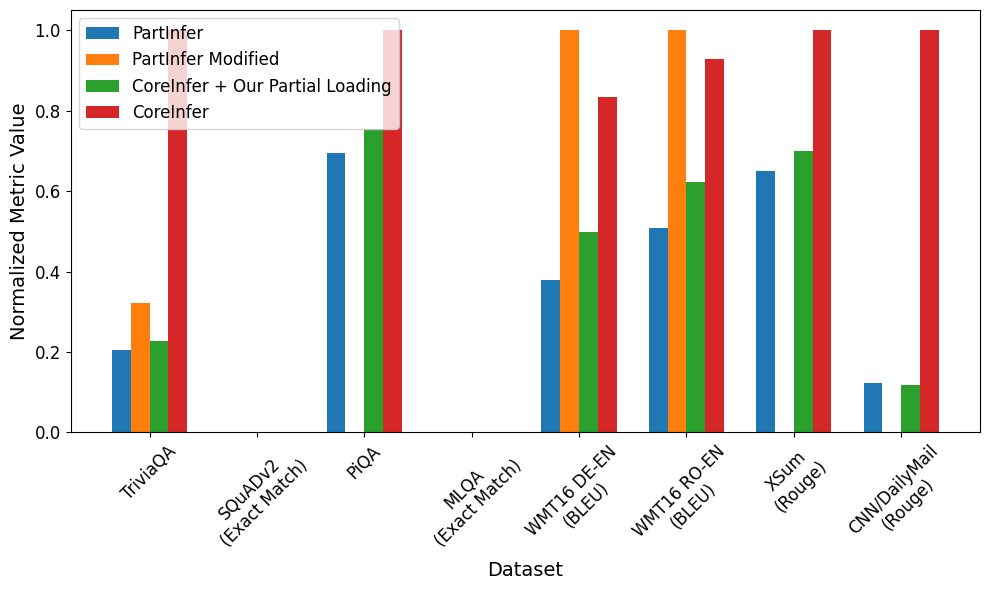

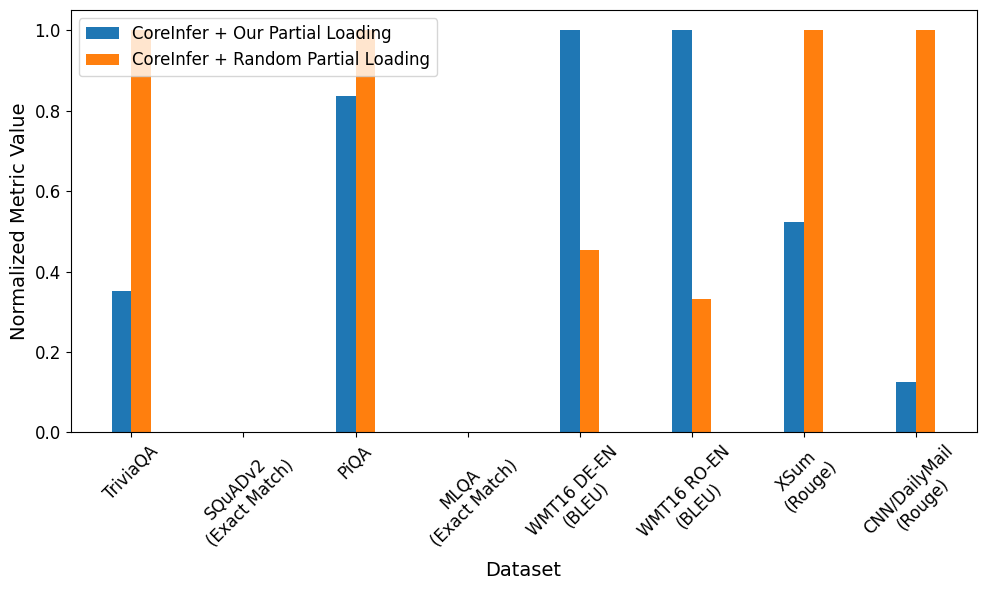

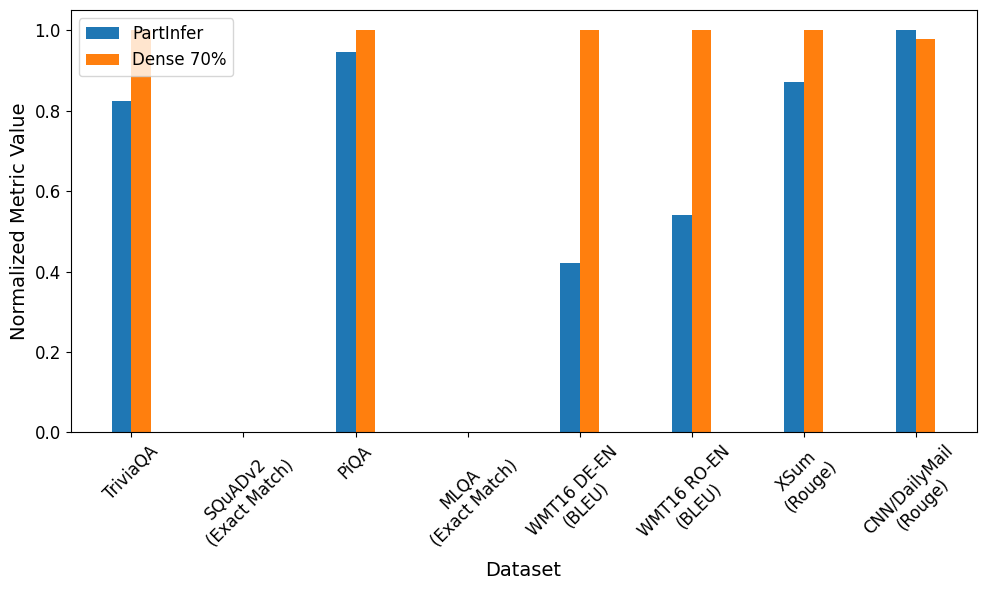

In [2]:
import numpy as np
import matplotlib.pyplot as plt

graphs = [
    ["partinfer", "coreinfer", "coreinfer_default_partial", "partinfer_modified"],
    ["coreinfer_default_partial", "coreinfer_random_partial"],
    ["partinfer", "dense"],
]

method_labels = {
    "partinfer": "PartInfer",
    "partinfer_modified": "PartInfer Modified",
    "coreinfer_default_partial": "CoreInfer + Our Partial Loading",
    "coreinfer_random_partial": "CoreInfer + Random Partial Loading",
    "coreinfer": "CoreInfer",
    "reference": "Reference",
    "dense": "Dense 70%"
}

labels = {
    "triviaqa": "TriviaQA",
    "squadv2": "SQuADv2\n(Exact Match)",
    "piqa": "PiQA",
    "mlqa_en_en": "MLQA\n(Exact Match)",
    "wmt16-de-en": "WMT16 DE-EN\n(BLEU)",
    "wmt16-ro-en": "WMT16 RO-EN\n(BLEU)",
    "xsum": "XSum\n(Rouge)",
    "cnn_dailymail": "CNN/DailyMail\n(Rouge)"
}

for graph in graphs:

    included_results = {}
    for dataset, metrics in results.items():
        included_results[dataset] = {}
        for method, value in metrics.items():
            if method in graph:
                included_results[dataset][method] = value
                
    # Normalize each key in results with max value
    for dataset, metrics in included_results.items():
        max_value = max(metrics.values())
        if max_value == 0:
            continue
        for method, value in metrics.items():
            metrics[method] = value / max_value

    # Prepare data for plotting
    method_names = list(next(iter(included_results.values())).keys())
    x = datasets
    bar_width = 0.175

    # Set up bar positions
    r = np.arange(len(x))
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, method in enumerate(method_names):
        y = [included_results[dataset][method] for dataset in x]
        ax.bar(r + i * bar_width, y, width=bar_width, label=method_labels[method])

    ax.set_xticks(r + bar_width * (len(method_names) - 1) / 2)
    ax.set_xticklabels(labels.values(), rotation=45, fontsize=16)
    ax.set_ylabel('Normalized Metric Value', fontsize=14)
    ax.set_xlabel('Dataset', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Analyze SpeedUp

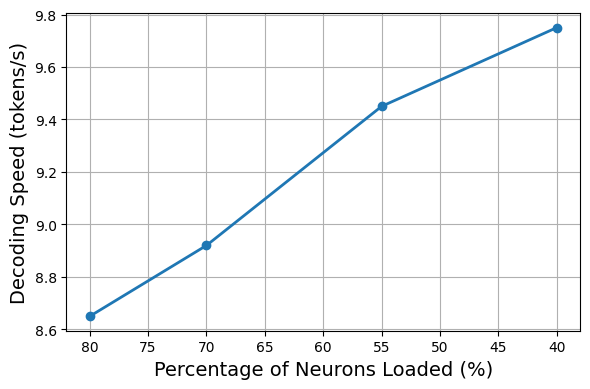

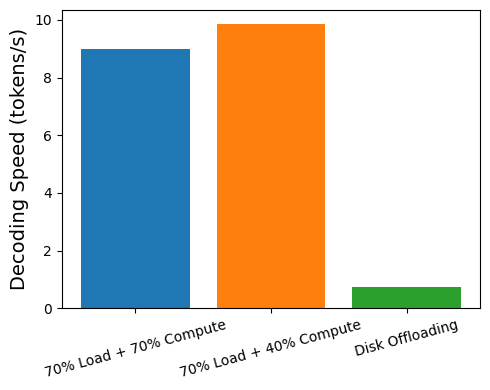

In [ ]:
import matplotlib.pyplot as plt

# ---------------- Graph 1: Partial Loading ----------------
loading_perc = [80, 70, 55, 40]
throughput_loading = [8.65, 8.92, 9.45, 9.75]

plt.figure(figsize=(6,4))
plt.plot(loading_perc, throughput_loading, marker='o', linewidth=2)
plt.xlabel("Percentage of Neurons Loaded (%)", fontsize=14)
plt.ylabel("Decoding Speed (tokens/s)", fontsize=14)
# plt.title("Effect of Partial Loading on Decoding Speed")
plt.grid(True)
plt.gca().invert_xaxis()  # more intuitive: less loading → more speed
plt.tight_layout()
# plt.savefig("partial_loading.png", dpi=300)
plt.show()

# ---------------- Graph 2: Partial Computation ----------------
methods = ["70% Load + 70% Compute", "70% Load + 40% Compute", "Disk Offloading"]
throughput_comp = [9.0, 9.85, 0.75]

plt.figure(figsize=(5,4))
bars = plt.bar(methods, throughput_comp, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

plt.ylabel("Decoding Speed (tokens/s)", fontsize=14)
plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)
plt.xticks(rotation=15)
# plt.ylim(8, max(throughput_comp) + 0.2)
# plt.title("Effect of Partial Computation on Decoding Speed")
plt.tight_layout()
# plt.savefig("partial_computation.png", dpi=300)
plt.show()
